## Libraries

In [1]:
import os 
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import cv2
from PIL import Image

from sklearn.externals import joblib
from sklearn import datasets
from skimage.feature import hog
from sklearn.svm import LinearSVC

## Import images

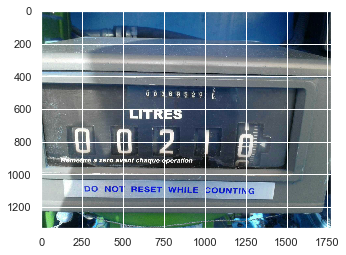

In [8]:
data_path = os.getcwd() + str('\\Dataset\\')
img = cv2.imread(data_path + str('\\HQ_analog\\0c5b6ae37471ed064c7ce6c21e5b4efd6b3b724a.jpg'))
plt.imshow(img)

## Method 1: Using HOG features

#http://hanzratech.in/2015/02/24/handwritten-digit-recognition-using-opencv-sklearn-and-python.html

In [3]:
dataset = datasets.fetch_openml('mnist_784', version=1, cache=True)

In [4]:
features = np.array(dataset.data, 'int16') 
labels = np.array(dataset.target, 'int')

list_hog_fd = []

for feature in features:
    fd = hog(feature.reshape((28, 28)), orientations=9, pixels_per_cell=(14, 14), cells_per_block=(1, 1), visualize=False)
    list_hog_fd.append(fd)
hog_features = np.array(list_hog_fd, 'float64')

In [6]:
clf = LinearSVC()
clf.fit(hog_features, labels)
joblib.dump(clf, "digits_cls.pkl", compress=3)

['digits_cls.pkl']

-1

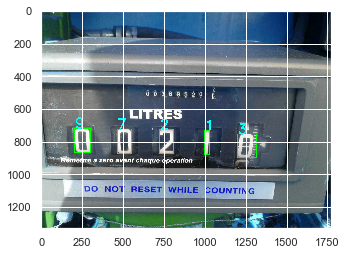

In [79]:
# Load the classifier
clf = joblib.load("digits_cls.pkl")

# Read the input image 
im = cv2.imread(data_path + str('\\HQ_analog\\0c5b6ae37471ed064c7ce6c21e5b4efd6b3b724a.jpg'))

# Convert to grayscale and apply Gaussian filtering
grayImage = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
#thresh, im_gray = cv2.threshold(grayImage, 150, 255, cv2.THRESH_BINARY)
#im_gray = cv2.GaussianBlur(im_gray, (5, 5), 0)

(thresh, im_th) = cv2.threshold(grayImage, 150, 255, cv2.THRESH_BINARY)

# Threshold the image
#ret, im_th = cv2.threshold(im_gray, 90, 255, cv2.THRESH_BINARY_INV)

# Find contours in the image
ctrs, hier = cv2.findContours(im_th.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Get rectangles contains each contour
#rects = [cv2.boundingRect(ctr) for ctr in ctrs]
rects = []

for ctr in ctrs:
    (x, y, w, h) = cv2.boundingRect(ctr)
    if w >= 10 and (h >= 100 and h <= 200): 
        rects.append(cv2.boundingRect(ctr))
        
for rect in rects:
    # Draw the rectangles
    cv2.rectangle(im, (rect[0], rect[1]), (rect[0] + rect[2], rect[1] + rect[3]), (0, 255, 0), 3) 
    # Make the rectangular region around the digit
    leng = int(rect[3] * 1.6)
    pt1 = int(rect[1] + rect[3] // 2 - leng // 2)
    pt2 = int(rect[0] + rect[2] // 2 - leng // 2)
    roi = im_th[pt1:pt1+leng, pt2:pt2+leng]
    
    # Resize the image
    roi = cv2.resize(roi, (28, 28), interpolation=cv2.INTER_AREA)
    roi = cv2.dilate(roi, (3, 3))
    
    # Calculate the HOG features
    roi_hog_fd = hog(roi, orientations=9, pixels_per_cell=(14, 14), cells_per_block=(1, 1), visualize=False)
    nbr = clf.predict(np.array([roi_hog_fd], 'float64'))
    cv2.putText(im, str(int(nbr[0])), (rect[0], rect[1]),cv2.FONT_HERSHEY_DUPLEX, 3, (0, 255, 255), 5)

plt.imshow(im)
cv2.waitKey()

## Method 2: Using digital decomposition

#https://www.pyimagesearch.com/2017/02/13/recognizing-digits-with-opencv-and-python/?fbclid=IwAR2AwpNNpOU_ZmTTjnueztaXVkA-_AckLTVRxDtRE-JQHSq116w04Z2Mc8E

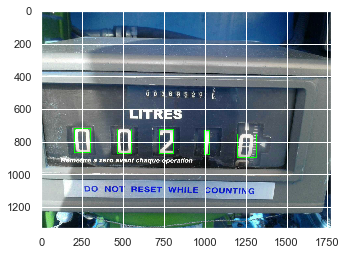

In [65]:
# define the dictionary of digit segments so we can identify
# each digit on the thermostat
from imutils import contours

DIGITS_LOOKUP = {
    (1, 1, 1, 0, 1, 1, 1): 0,
    (0, 0, 1, 0, 0, 1, 0): 1,
    (1, 0, 1, 1, 1, 1, 0): 2,
    (1, 0, 1, 1, 0, 1, 1): 3,
    (0, 1, 1, 1, 0, 1, 0): 4,
    (1, 1, 0, 1, 0, 1, 1): 5,
    (1, 1, 0, 1, 1, 1, 1): 6,
    (1, 0, 1, 0, 0, 1, 0): 7,
    (1, 1, 1, 1, 1, 1, 1): 8,
    (1, 1, 1, 1, 0, 1, 1): 9,
    (0, 1, 0, 0, 0, 1, 0):10,
    (0, 1, 0, 1, 1, 1, 0):11,
    (0, 0, 0, 1, 0, 0, 0):12
}

# Read the input image 
im = cv2.imread(data_path + str('\\HQ_analog\\0c5b6ae37471ed064c7ce6c21e5b4efd6b3b724a.jpg'))
output = im

# Convert to grayscale and apply Gaussian filtering
grayImage = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
#thresh, im_gray = cv2.threshold(grayImage, 150, 255, cv2.THRESH_BINARY)
#im_gray = cv2.GaussianBlur(im_gray, (5, 5), 0)

(thresh, im_th) = cv2.threshold(grayImage, 150, 255, cv2.THRESH_BINARY)

thresh = cv2.threshold(im_th, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]

# Threshold the image
#ret, im_th = cv2.threshold(im_gray, 90, 255, cv2.THRESH_BINARY_INV)

# Find contours in the image
ctrs, hier = cv2.findContours(im_th.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Get rectangles contains each contour
#rects = [cv2.boundingRect(ctr) for ctr in ctrs]
digitCnts = [] # rects in previous method

for ctr in ctrs:
    (x, y, w, h) = cv2.boundingRect(ctr)
    if w >= 10 and (h >= 100 and h <= 200): 
        digitCnts.append(ctr)

for c in digitCnts:
    (x, y, w, h) = cv2.boundingRect(c)
    cv2.rectangle(im, (x, y), (x + w, y + h), (3, 255, 0), 3)
   
plt.imshow(im)

In [82]:
for c in digitCnts:
    (x, y, w, h) = cv2.boundingRect(c)
    #cv2.rectangle(im, (x, y), (x + w, y + h), (0, 255, 0), 3)
    roi = thresh[y:y + h, x:x + w]
 
    # compute the width and height of each of the 7 segments
    # we are going to examine
    (roiH, roiW) = roi.shape
    (dW, dH) = (int(roiW * 0.25), int(roiH * 0.15))
    dHC = int(roiH * 0.05)
 
    # define the set of 7 segments
    segments = [
        ((0, 0), (w, dH)), # top
        ((0, 0), (dW, h // 2)), # top-left
        ((w - dW, 0), (w, h // 2)), # top-right
        ((0, (h // 2) - dHC) , (w, (h // 2) + dHC)), # center
        ((0, h // 2), (dW, h)), # bottom-left
        ((w - dW, h // 2), (w, h)), # bottom-right
        ((0, h - dH), (w, h)) # bottom
    ]
    on = [0] * len(segments)
    
    # loop over the segments
    for (i, ((xA, yA), (xB, yB))) in enumerate(segments):
        # extract the segment ROI, count the total number of
        # thresholded pixels in the segment, and then compute
        # the area of the segment
        segROI = roi[yA:yB, xA:xB]
        total = cv2.countNonZero(segROI)
        area = (xB - xA) * (yB - yA)
 
        # if the total number of non-zero pixels is greater than
        # 50% of the area, mark the segment as "on"
        if total / float(area) > 0.5:
            on[i]= 1
 
    # lookup the digit and draw it on the image
    digit = DIGITS_LOOKUP[tuple(on)]
    digits.append(digit)
    cv2.rectangle(output, (x, y), (x + w, y + h), (0, 255, 0), 1)
    cv2.putText(output, str(digit), (x - 10, y - 10),
        cv2.FONT_HERSHEY_SIMPLEX, 0.65, (0, 255, 0), 2)
    
print(u"{}{}.{} \u00b0C".format(*digits))
plt.imshow(output)
cv2.waitKey(0)


TypeError: 'float' object is not subscriptable